In [1]:
import json
import influxdb
import pandas as pd
import matplotlib.pyplot as plt
from odapi.formats import InfluxDB
from odapi.toolbox.psychro import Constants, Mix

In [2]:
with open("../../../../secrets/lht65.json") as fh:
    client = influxdb.InfluxDBClient(**json.load(fh))

In [3]:
q = client.query('SELECT "value" FROM /device_frmpayload_data_node_.*/ GROUP BY "device_name", "location"')

In [4]:
df = InfluxDB.to_frame(q.raw)

In [5]:
df.head()

,time,value,serie_name,location,device_name
0,2020-08-15 09:22:02.469000+00:00,61.5,device_frmpayload_data_node_humidity,outdoor,node-T011
1,2020-08-15 09:39:46.499000+00:00,64.6,device_frmpayload_data_node_humidity,outdoor,node-T011
2,2020-08-15 09:59:45.590000+00:00,66.2,device_frmpayload_data_node_humidity,outdoor,node-T011
3,2020-08-15 10:19:46.211000+00:00,64.8,device_frmpayload_data_node_humidity,outdoor,node-T011
4,2020-08-15 10:39:46.179000+00:00,64.3,device_frmpayload_data_node_humidity,outdoor,node-T011


In [6]:
df["time"] = df["time"].dt.round("20T")

In [7]:
df["serie_name"] = df["serie_name"].apply(lambda x: x.split("_")[-1])
df["location"] = df["location"].replace({'badroom-children': 'bathroom-children'})

In [8]:
dc = df.pivot_table(index="time", columns=["serie_name", "location"], values="value")

In [9]:
dc = dc[dc["temperature"]<300]

In [10]:
dc = dc.interpolate()

In [11]:
dc.head()

serie_name                         humidity                  \
location                  bathroom-children bathroom-parent   
time                                                          
2020-08-15 09:20:00+00:00              80.7            58.5   
2020-08-15 09:40:00+00:00              80.2            57.6   
2020-08-15 10:00:00+00:00              75.2            57.8   
2020-08-15 10:20:00+00:00              63.2            55.4   
2020-08-15 10:40:00+00:00              59.4            68.4   

serie_name                                                                \
location                  bedroom-child-left kitchen living-room outdoor   
time                                                                       
2020-08-15 09:20:00+00:00              58.90    59.4        59.8    61.5   
2020-08-15 09:40:00+00:00              60.20    59.6        59.4    64.6   
2020-08-15 10:00:00+00:00              60.00    55.3        59.0    66.2   
2020-08-15 10:20:00+00:00              57.95    53.5        55.8    64.8   
2020-08-15 10:40:00+00:00              55.90    52.3        55.3    64.3   

serie_name                      temperature                  \
location                  bathroom-children bathroom-parent   
time                                                          
2020-08-15 09:20:00+00:00             26.77           26.16   
2020-08-15 09:40:00+00:00             27.33           26.14   
2020-08-15 10:00:00+00:00             27.64           26.72   
2020-08-15 10:20:00+00:00             27.63           26.97   
2020-08-15 10:40:00+00:00             27.57           27.21   

serie_name                                                                
location                  bedroom-child-left kitchen living-room outdoor  
time                                                                      
2020-08-15 09:20:00+00:00              26.28   26.37       25.96   25.81  
2020-08-15 09:40:00+00:00              26.29   26.50       26.11   24.90  
2020-08-15 10:00:00+00:00              26.45   27.37       26.26   24.43  
2020-08-15 10:20:00+00:00              26.53   27.83       26.41   24.37  
2020-08-15 10:40:00+00:00              26.61   27.97       26.49   24.54

In [12]:
T = dc["temperature"]
RH = dc["humidity"]

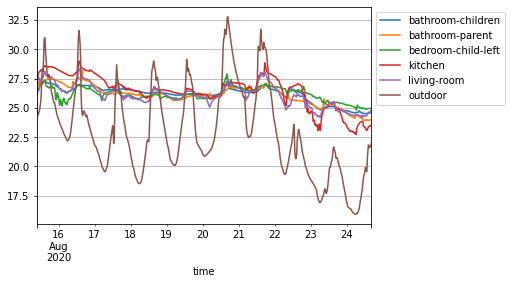

In [13]:
axe = T.plot()
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

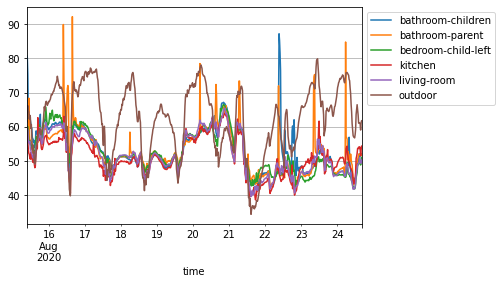

In [14]:
axe = RH.plot()
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

In [15]:
TK = T + Constants.T0K
pw = pd.DataFrame(Mix.pisow(TK.values , phi=RH.values/100.)/1000., columns = TK.columns, index = T.index)

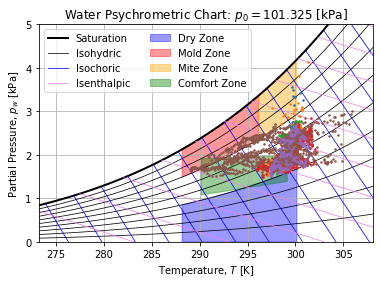

In [16]:
axe = Mix.plot()
axe.plot(TK, pw, ".", markersize=3)

In [17]:
df2 = pd.read_csv("Psychro_data.csv", header=[0,1], parse_dates=[0], index_col=0)
df2.head()

channel             battery_status                                          \
device_name              node-T001 node-T002 node-T003 node-T004 node-T005   
timestamp                                                                    
2019-10-26 18:15:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 18:30:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 18:45:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 19:00:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 19:15:00            3.0       3.0       3.0       3.0       NaN   

channel             battery_voltage                                          \
device_name               node-T001 node-T002 node-T003 node-T004 node-T005   
timestamp                                                                     
2019-10-26 18:15:00        3.108000  3.114000  3.094000  3.108000       NaN   
2019-10-26 18:30:00        3.106667  3.115000  3.094667  3.107667       NaN   
2019-10-26 18:45:00        3.106000  3.113667  3.095333  3.107000       NaN   
2019-10-26 19:00:00        3.106000  3.113000  3.094000  3.107667       NaN   
2019-10-26 19:15:00        3.105333  3.115000  3.094667  3.106667       NaN   

channel              ... sensor_code                                          \
device_name          ...   node-T001 node-T002 node-T003 node-T004 node-T005   
timestamp            ...                                                       
2019-10-26 18:15:00  ...         1.0       1.0       1.0       1.0       NaN   
2019-10-26 18:30:00  ...         1.0       1.0       1.0       1.0       NaN   
2019-10-26 18:45:00  ...         1.0       1.0       1.0       1.0       NaN   
2019-10-26 19:00:00  ...         1.0       1.0       1.0       1.0       NaN   
2019-10-26 19:15:00  ...         1.0       1.0       1.0       1.0       NaN   

channel             sensor_temperature                                  \
device_name                  node-T001 node-T002  node-T003  node-T004   
timestamp                                                                
2019-10-26 18:15:00          17.340000     20.43  20.530000  20.780000   
2019-10-26 18:30:00          17.410000     20.39  20.476667  20.703333   
2019-10-26 18:45:00          17.496667     20.33  20.410000  20.810000   
2019-10-26 19:00:00          17.540000     20.29  20.350000  20.830000   
2019-10-26 19:15:00          17.453333     20.25  20.310000  20.810000   

channel                        
device_name         node-T005  
timestamp                      
2019-10-26 18:15:00       NaN  
2019-10-26 18:30:00       NaN  
2019-10-26 18:45:00       NaN  
2019-10-26 19:00:00       NaN  
2019-10-26 19:15:00       NaN  

[5 rows x 30 columns]

In [18]:
df2 = df2.loc["2019-11-09 09:30:00":"2019-11-16 09:30:00",:]

In [19]:
T = df2["node_temperature"]
RH = df2["node_humidity"]

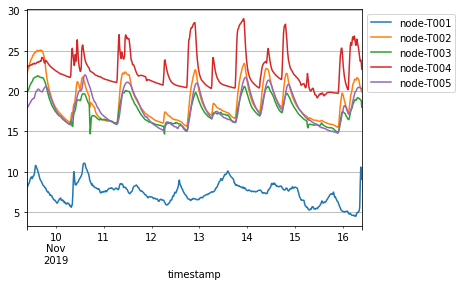

In [20]:
axe = T.plot()
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

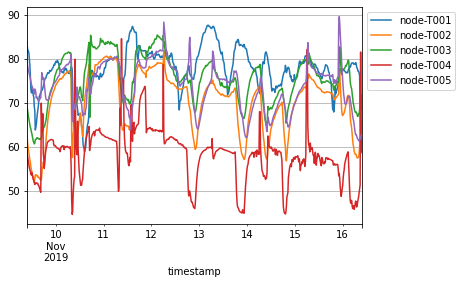

In [21]:
axe = RH.plot()
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

In [22]:
TK = T + Constants.T0K
pw = pd.DataFrame(Mix.pisow(TK.values , phi=RH.values/100.)/1000., columns = TK.columns, index = T.index)

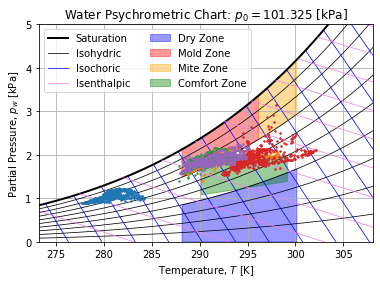

In [23]:
axe = Mix.plot()
axe.plot(TK, pw, ".", markersize=3)